In [ ]:
!pip install fast-pytorch-kmeans kmeans_pytorch text2vec

In [21]:
import torch
import numpy as np

from kmeans_pytorch import kmeans
from text2vec import SentenceModel

embedding

## 文本编码

In [22]:
embedder = SentenceModel()

2024-03-14 09:30:34.174 | DEBUG    | text2vec.sentence_model:__init__:80 - Use device: cuda


In [23]:
# Corpus with example sentences
corpus = [
    '花呗更改绑定银行卡',
    '我什么时候开通了花呗',
    'A man is eating food.',
    'A man is eating a piece of bread.',
    'The girl is carrying a baby.',
    'A man is riding a horse.',
    'A woman is playing violin.',
    'Two men pushed carts through the woods.',
    'A man is riding a white horse on an enclosed ground.',
]
corpus_embeddings = embedder.encode(corpus)

In [24]:
corpus_embeddings = torch.from_numpy(corpus_embeddings).to('cuda')

In [25]:
type(corpus_embeddings), corpus_embeddings.shape

(torch.Tensor, torch.Size([9, 768]))

In [38]:
num_class = 3 # 分类类别数

## 聚类可视化类

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class KMeansPlot:

    def __init__(self, numClass=4, func_type='PCA'):
        if func_type == 'PCA':
            self.func_plot = PCA(n_components=2)
        elif func_type == 'TSNE':
            from sklearn.manifold import TSNE
            self.func_plot = TSNE(2)
        self.numClass = numClass

    def plot_cluster(self, result, pos, cluster_centers=None):
        plt.figure(2)
        Lab = [[] for i in range(self.numClass)]
        index = 0
        for labi in result:
            Lab[labi].append(index)
            index += 1
        color = ['oy', 'ob', 'og', 'cs', 'ms', 'bs', 'ks', 'ys', 'yv', 'mv', 'bv', 'kv', 'gv', 'y^', 'm^', 'b^', 'k^',
                    'g^'] * 3

        for i in range(self.numClass):
            x1 = []
            y1 = []
            for ind1 in pos[Lab[i]]:
                # print ind1
                try:
                    y1.append(ind1[1])
                    x1.append(ind1[0])
                except:
                    pass
            plt.plot(x1, y1, color[i])

        if cluster_centers is not None:
            #绘制初始中心点
            x1 = []
            y1 = []

            for ind1 in cluster_centers:
                try:
                    y1.append(ind1[1])
                    x1.append(ind1[0])
                except:
                    pass

            plt.plot(x1, y1, "rv") #绘制中心
        plt.show()

    def plot(self, weight, label, cluster_centers=None):
        pos = self.func_plot.fit_transform(weight)
        # 高纬的中心点坐标，也经过降纬处理
        cluster_centers = self.func_plot.fit_transform(cluster_centers)
        self.plot_cluster(list(label), pos, cluster_centers)

## kmeans_pytorch

In [60]:
from kmeans_pytorch import kmeans

labels, cluster_centers = kmeans(
    X=corpus_embeddings,
    num_clusters=num_class,
    distance='euclidean',
    device=torch.device('cuda:0')
)

running k-means on cuda:0..


[running kmeans]: 2it [00:00, 247.15it/s, center_shift=0.000000, iteration=2, tol=0.000100]


In [61]:
labels

tensor([0, 0, 1, 1, 2, 1, 2, 1, 1])

In [62]:
cluster_centers

tensor([[ 0.3271, -0.2714,  0.9217,  ..., -0.6270, -0.1306, -0.0952],
        [ 0.2802, -0.2230,  0.1945,  ...,  0.0356, -1.1100,  0.3093],
        [ 0.2819, -1.1449,  0.2388,  ..., -0.7908, -1.7649, -0.1390]])

### 结果

In [63]:
class_data = {
    i:[]
    for i in range(num_class)
}

for text,cls in zip(corpus, labels):
    class_data[cls.item()].append(text)

class_data

{0: ['花呗更改绑定银行卡', '我什么时候开通了花呗'],
 1: ['A man is eating food.',
  'A man is eating a piece of bread.',
  'A man is riding a horse.',
  'Two men pushed carts through the woods.',
  'A man is riding a white horse on an enclosed ground.'],
 2: ['The girl is carrying a baby.', 'A woman is playing violin.']}

### 绘图

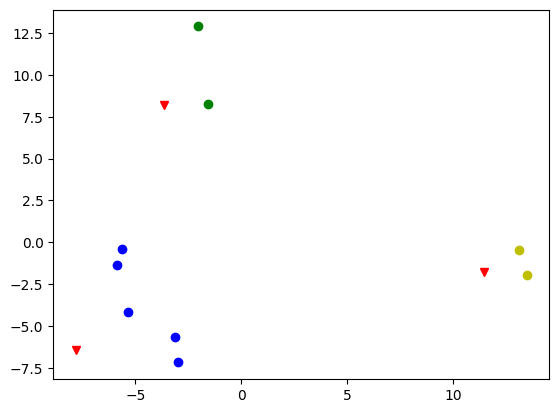

In [64]:
k_plot = KMeansPlot(num_class)

k_plot.plot(
    corpus_embeddings.to('cpu'), # 文本编码的向量
    labels.to('cpu'), # 聚类的结果
    cluster_centers.to('cpu') # 聚类的高纬中心点，再降纬到2D
)

## fast_pytorch_kmeans

In [51]:
# kmeans
# from kmeans_pytorch import kmeans
from fast_pytorch_kmeans import KMeans


kmeans = KMeans(n_clusters=num_class, mode='euclidean', verbose=1)
labels = kmeans.fit_predict(corpus_embeddings)

used 2 iterations (0.0039s) to cluster 9 items into 3 clusters


In [52]:
# 高纬到中心点坐标
kmeans.centroids

tensor([[ 0.2819, -1.1449,  0.2388,  ..., -0.7908, -1.7649, -0.1390],
        [ 0.2802, -0.2230,  0.1945,  ...,  0.0356, -1.1100,  0.3093],
        [ 0.3271, -0.2714,  0.9217,  ..., -0.6270, -0.1306, -0.0952]],
       device='cuda:0')

### 结果

In [53]:
class_data = {
    i:[]
    for i in range(num_class)
}

for text,cls in zip(corpus, labels):
    class_data[cls.item()].append(text)

class_data

{0: ['The girl is carrying a baby.', 'A woman is playing violin.'],
 1: ['A man is eating food.',
  'A man is eating a piece of bread.',
  'A man is riding a horse.',
  'Two men pushed carts through the woods.',
  'A man is riding a white horse on an enclosed ground.'],
 2: ['花呗更改绑定银行卡', '我什么时候开通了花呗']}

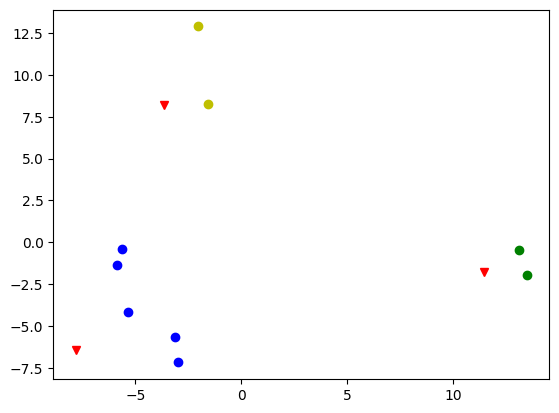

In [54]:
k_plot = KMeansPlot(num_class)
k_plot.plot(
    corpus_embeddings.to('cpu'),
    labels.to('cpu'),
    kmeans.centroids.to('cpu')
)